In [1]:
###
# Handwriting Recognition Project - Task 3
# Group 16
# 03-06-2022
#
# This code was largely based on the example presented in https://github.com/NielsRogge/Transformers-Tutorials/blob/master/TrOCR/Fine_tune_TrOCR_on_IAM_Handwriting_Database_using_native_PyTorch.ipynb
###

In [2]:
# Install the Hugging Face TROCR base model
!pip install -q git+https://github.com/huggingface/transformers.git

You should consider upgrading via the 'D:\Documenten\Universiteit_master\HR\task_3\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
# Install jiwer
!pip install -q datasets jiwer

You should consider upgrading via the 'D:\Documenten\Universiteit_master\HR\task_3\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [4]:
# Import pandas to allow working with data frames
import pandas as pd

# Make a data frame of the .txt data
TRAIN_DATA_DIR = "data/"
raw_txt_df = pd.read_fwf(TRAIN_DATA_DIR + 'iam_lines_gt.txt', header=None)
first_column = raw_txt_df.iloc[::2]
second_column = raw_txt_df.iloc[1::2]
txt_df = pd.concat([first_column.reset_index(drop=True), second_column.reset_index(drop=True)], axis=1)
txt_df = pd.DataFrame(txt_df)
txt_df = txt_df.set_axis(['file_name', 'text'], axis=1)

In [5]:
# Import a train_test_split function to allow for validation
from sklearn.model_selection import train_test_split

# Use a 80-20 train-validation split
train_txt_df, val_txt_df = train_test_split(txt_df, test_size=0.2)
train_txt_df.reset_index(drop=True, inplace=True)
val_txt_df.reset_index(drop=True, inplace=True)

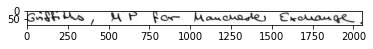

In [6]:
import os
import cv2
import matplotlib.pyplot as plt

IMG_TRAIN_DATA_DIR = 'data/img/'

cnt = 0

# Iterate over the IAM data, generate binary images and show these
# While the images are not used, for know, this provides an illustration
for filename in os.listdir(IMG_TRAIN_DATA_DIR):
    # Get an image
    f = os.path.join(IMG_TRAIN_DATA_DIR, filename)
    img = cv2.imread(f)
    
    # Present 10 images in total
    cnt = cnt + 1
    if cnt == 10:
      break

    # Threshold the image
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (thresh, threshold_img) = cv2.threshold(gray_img, 200, 255, cv2.THRESH_BINARY)
    window_name = "img"
    
    # Show the resulting binary image
    plt.imshow(threshold_img, cmap='gray')
    plt.imshow(gray_img, cmap='gray')

In [10]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
# from keras.preprocessing.image import img_to_array
from matplotlib import pyplot

# Create an Image Data Generator for augmentation
# Rotate, zoom and shear the images
augmentator = ImageDataGenerator(
	rotation_range = 0.5,
	shear_range = 0.5,
	fill_mode = "constant",
    cval = 255)

# Create new data frames in which the augmented image names are included
new_train_txt_df = train_txt_df.copy()
new_val_txt_df = val_txt_df.copy()

AUGMENT_DATA = False

if AUGMENT_DATA:

    cnt = 0

    # Loop through all images
    for filename in os.listdir(IMG_TRAIN_DATA_DIR):
        cnt = cnt + 1
        
        # Get the image
        f = os.path.join(IMG_TRAIN_DATA_DIR, filename)
        img = cv2.imread(f)  
        
        # Reshape the image so that it can be used
        x = np.array(img)
        x = x.reshape((1, ) + x.shape)  
        
        # Create the folder in which the augmented images are saved
        aug_image_folder = "data/img_aug/"
        
        i = 0
        # Generate 5 augmented images per image
        for batch in augmentator.flow(x, batch_size = 1):
            # Save the augmented image
            name = str(i) + "_" + filename
            cv2.imwrite(f'{aug_image_folder}/{name}',batch[0,:,:,:])
            
            # Add the augmented image name to a txt dataframe
            df_filename = new_train_txt_df[new_train_txt_df['file_name'] == filename]
            df_filename['file_name'] = name
            new_train_txt_df = new_train_txt_df.append([df_filename],ignore_index=True)
            df_filename = new_val_txt_df[new_val_txt_df['file_name'] == filename]
            df_filename['file_name'] = name
            new_val_txt_df = new_val_txt_df.append([df_filename],ignore_index=True)
            
            i += 1
            if i > 5: 
                # Remove the original image from the txt dataframes
                new_train_txt_df = new_train_txt_df.drop(new_train_txt_df[new_train_txt_df['file_name'] == filename].index)
                new_val_txt_df = new_val_txt_df.drop(new_val_txt_df[new_val_txt_df['file_name'] == filename].index)
                break
    new_train_txt_df.reset_index(drop=True, inplace=True)
    new_val_txt_df.reset_index(drop=True, inplace=True)

C:\Users\irisk\AppData\Local\Temp\ipykernel_32608\2892363653.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filename['file_name'] = name
C:\Users\irisk\AppData\Local\Temp\ipykernel_32608\2892363653.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train_txt_df = new_train_txt_df.append([df_filename],ignore_index=True)
C:\Users\irisk\AppData\Local\Temp\ipykernel_32608\2892363653.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_val_txt_df = new_val_txt_df.append([df_filename],ignore_index=True)
C:\Users\irisk\AppData\Local\Temp\ipykernel_32608\289236

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

# Create a class for the IAM data (largely based on https://github.com/NielsRogge/Transformers-Tutorials/blob/master/TrOCR/Fine_tune_TrOCR_on_IAM_Handwriting_Database_using_native_PyTorch.ipynb)
class IAMDataset(Dataset):
    
    # Initialise 
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
    
    # Return the length
    def __len__(self):
        return len(self.df)
    
    # Get an item from the data
    def __getitem__(self, idx):
        # Get the file name and corresponding text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]

        # Get the image
        image = cv2.imread(self.root_dir + file_name)

        # Create a binary image from the original image (to get rid of background noise)
        (thresh, threshold_img) = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY)
        threshold_img = np.img_to_array(threshold_img)

        # Get the pixel values
        pixel_values = self.processor(threshold_img, return_tensors="pt").pixel_values

        # Get labels by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        
        # Ensure that the PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        
        return encoding

In [ ]:
from transformers import TrOCRProcessor

# Use the base TROCR model as a processor
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

# Create IAM datasets using the IAMDataset class
train_dataset = IAMDataset(root_dir='data/img_aug/',
                           df=new_train_txt_df,
                           processor=processor)
val_dataset = IAMDataset(root_dir='data/img_aug/',
                           df=new_val_txt_df,
                           processor=processor)


In [ ]:
from torch.utils.data import DataLoader

# Create data loaders for the training and validation data sets
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
eval_dataloader = DataLoader(val_dataset, batch_size=4)

In [ ]:
from transformers import VisionEncoderDecoderModel
import torch

# Use a GPU if that is possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the base TROCR model
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")
model.to(device)

In [ ]:
# Set tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

# Set the vocab size
model.config.vocab_size = model.config.decoder.vocab_size

# Set beam search para
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
from datasets import load_metric

# Use the character error rate for evaluation
cer_metric = load_metric("cer")

In [ ]:
# Compute the character error rate based on text predictions and actual text
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [ ]:
import torch

# Empty the GPU cache
torch.cuda.empty_cache()

In [ ]:
from transformers import AdamW
from tqdm.notebook import tqdm

# Use an AdamW optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Loop over the IAM dataset multiple times
for epoch in range(10):
   # Train the model
   model.train()
   train_loss = 0.0
   # Go through the IAM data
   for batch in tqdm(train_dataloader):
      for k,v in batch.items():
        batch[k] = v.to(device)

      # Do the forward and backward pass
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
        
      # Update the loss
      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
    
   # Evaluate the model with validation
   model.eval()
   valid_cer = 0.0
   with torch.no_grad():
     for batch in tqdm(eval_dataloader):
       outputs = model.generate(batch["pixel_values"].to(device))
       # Compute the character error rate
       cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
       valid_cer += cer 

   print("Validation CER:", valid_cer / len(eval_dataloader))

# Save the model
model.save_pretrained("./")

In [ ]:
import sys

# Use the user input as the path to the test data
test_path = sys.argv[1:]
# UNCOMMENT the following and change the test path if that works better
# test_path = "../some_path/some_more_path/"

# Create a dataframe for the test data text (unlabeled)
filenames = os.listdir(test_path)
texts = [""] * 5
filenames_df = pd.DataFrame(filenames)
texts_df = pd.DataFrame(texts)
test_txt_df = pd.concat([filenames_df, texts_df], axis=1)
test_txt_df = test_txt_df.set_axis(['file_name', 'text'], axis=1)

# Load the trained model
model_2 = VisionEncoderDecoderModel.from_pretrained("./")
model_2.to(device)

# Use the IAMDataset class to save the test data
test_dataset = IAMDataset(root_dir=test_path,
                           df=test_txt_df,
                           processor=processor)
test_dataloader = DataLoader(test_dataset, batch_size=1)

cnt = 0

# Go through the test data and predict the handwritten text
for batch in tqdm(test_dataloader):
    
    # Use the model to predict
    pixel_values = batch["pixel_values"].to(device)
    outputs = model.generate(pixel_values)

    # Decode the prediction
    pred_str = processor.batch_decode(outputs, skip_special_tokens=True)
    
    # Save the predicted text
    text_filename = test_txt_df.iloc[[cnt]]
    text_filename = text_filename.iloc[0]["file_name"]
    text_filename = text_filename.replace('.png', '.txt')
    cnt = cnt + 1
    with open(text_filename, 'w') as f:
        f.write(pred_str[0])